# Import

In [3]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
from matplotlib import interactive
import timeit
import ipywidgets as widgets 
from ipywidgets import interactive, interact
from matplotlib import cm
%matplotlib inline
from matplotlib import animation, rc 
from IPython.display import HTML

In [4]:
! git clone https://github.com/ChihYuLee/Thin-film-optics-simulation-.git

fatal: destination path 'Thin-film-optics-simulation-' already exists and is not an empty directory.


# Function

In [5]:
def read_refractive_index_file(materials,min_lambda=300):
    """

    Parameters
    ----------
    materials : Layer of materials are used 
    min_lambda : Minimum wavelength of interest 

    Returns
    -------
    wavelengths: Wavelenths contained in txt file 
    indexes: Different Indexes of n k as a function of wavelengths in amorphous and crystalline states
    (n_crystalline, k_crystalline, n_amorphous, k_amorphous) or (n, k)
    extrapolated: Extrapolated values 

    """
    
    global wavelengths, indexes, extrapolated
    wavelengths=None
    indexes=None
    extrapolated= None
    
    
    if materials== "GST":
        file_data = np.loadtxt("/Thin-film-optics-simulation-/refractive_index_GST_pei.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]
    
    #with max_lambda_interp=1745
    elif materials=="AIST":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_AIST.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:] # 4 columns 
        
        max_lambda_interp=1745
        extrapolated=np.zeros((max_lambda_interp-min_lambda+1,indexes.shape[1]))
        for i in range(extrapolated.shape[1]):
            f=interpolate.interp1d(wavelengths.flatten(), indexes[:,i], fill_value='extrapolate')
            extrapolated[:,i]= f(np.arange(min_lambda, max_lambda_interp+1))
    
    elif materials== "ITO": 
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_ITO_Ellipsometry_meausred .txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:] #only 2 columns 
        indexes=np.tile(indexes, (1, 2))
    
    #Compared with Pei
    elif materials== "Pt":
        file_data = np.loadtxt("Thin-film-optics-simulation-/Pt.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
    #Compared with Pei
    elif materials== "Ag":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_Ag_Ellipsometry_meausred.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
    #Longer Spectrum with max_lambda_interp=10000
    elif materials== "Ag2":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_Ag_long.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[:,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
        max_lambda_interp=10000
        extrapolated=np.zeros((max_lambda_interp-min_lambda+1,indexes.shape[1]))
        for i in range(extrapolated.shape[1]):
            f=interpolate.interp1d(wavelengths.flatten(), indexes[:,i], fill_value='extrapolate')
            extrapolated[:,i]= f(np.arange(min_lambda, max_lambda_interp+1))
        
    #Compared with Pei 
    elif materials== "SiO2":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_SiO2_Lemarchand 2013_Thin Film.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
    elif materials== "Ge":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_Ge.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
    elif materials== "TiO2":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_TiO2.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
    
    elif materials== "SbSe":
      #10 nm or 15 nm (Si) or 20 nm 
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_SbSe_Ellipsometry_meausred_20nm.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #4 columns
     

    return wavelengths, indexes, extrapolated

def transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, number_layers, n, k, d, pol):
    
    """
    Parameters
    ------
    theta0 : Incident angle in degrees
    n0 : Refraction index of incident medium 
    max_lambda : Maximum lambda to run simulation / Beware: some materials n and k are given up to 800nm
    min_lambda : Minimum lambda to run simulation
    number_layers :  Total number of layers (without counting air)
    n : Refractive index n of crystalline or amorphous states, shape= (wavelengths,layers) #(500,5)
    k : Refractive index k of crystalline or amorphous states = (wavelengths, layers)#(500,5)
    d : Layers of thickness
    pol : Choose either TE or TM polarization (relevant under oblique incidence)


    Returns
    -------
    #array containing X, A, R, T, Phi, Psi
    X: wavelengths in nm 
    A: Apsorption 
    R: Reflection
    T: Transmittance 
    Phi: Phase difference of R in stack of layers 
    Psi: Phase difference of T in stack of layers 
    
    """
    # Parameters for calculation 
    matrix_lambda= max_lambda-min_lambda
    admitanceinvacuum=2.6544*10**(-3)
    m= np.array([[1,0],[0,1]],dtype=complex)
    y=np.empty((matrix_lambda+1, number_layers),dtype=complex)
    eta= np.empty((matrix_lambda+1, number_layers),dtype=complex)
    theta= np.empty((matrix_lambda+1, number_layers),dtype=complex)
    delta= np.empty((matrix_lambda+1, number_layers-1),dtype=complex)

    
    
    # First layer (PCM)---> theta1, eta1, y1
    theta1= np.arcsin(np.divide(n0*np.sin(theta0),(n[:,0]-1j*k[:,0])))
    y0=n0*admitanceinvacuum 
    y1= (n[:,0]-1j*k[:,0])*admitanceinvacuum 
    if pol=='TE':
        eta0= y0*np.cos(theta0)
        eta1= y1*np.cos(theta1)
    elif pol=='TM':
        eta0= y0/np.cos(theta0)
        eta1= y1/np.cos(theta1)
    else:
        print('Ther is an error')
 
    y[:,0]=y1
    eta[:,0]=eta1
    theta[:,0]=theta1
    M=np.empty((2,2,matrix_lambda+1), dtype=complex)
    for j in range(matrix_lambda+1):
        M[:,:,j]= m
    
    
    
    # Rest of layers 
    lambda_complete= np.arange(min_lambda, max_lambda+1)*10**(-9)
    A=np.empty(matrix_lambda+1)
    R=np.empty(matrix_lambda+1)
    T=np.empty(matrix_lambda+1)
    Phi=np.empty(matrix_lambda+1)
    Psi=np.empty(matrix_lambda+1)
  
        

    
    for i in range(number_layers-1): #different layers
        
        theta[:,i+1]= np.arcsin(np.divide(n[:,i]*np.sin(theta[:,i]), (n[:,i+1]-1j*k[:,i+1])))
        y[:,i+1]=(n[:,i+1]-1j*k[:,i+1])*admitanceinvacuum
        
        if pol=='TE':
            eta[:,i+1]= y[:,i+1]*np.cos(theta[:,i+1])
        elif pol=='TM':
            eta[:,i+1]= y[:,i+1]/np.cos(theta[:,i+1])
        else:
            print('Ther is an error')
        

        delta[:,i]=2*np.pi*d[i]*np.sqrt(n[:,i]**2
                                        -k[:,i]**2
                                        -n0*(np.sin(theta0))**2
                                        -2j*(n[:,i]*k[:,i]))/lambda_complete
        
        s= np.array([[np.cos(delta[:,i]),1j*np.sin(delta[:,i])/eta[:,i]]
                     ,[1j*eta[:,i]*np.sin(delta[:,i]),np.cos(delta[:,i])]], 
                    dtype= complex)


        
        for j in range(s.shape[-1]): #different wavelengths
            M[:,:,j]= M[:,:,j]@s[:,:,j]
            

    #Outputs       
    MM= np.empty((s.shape[0],s.shape[-1]), complex)
    for j in range(s.shape[-1]):  #different wavelengths
        MM[:,j]= M[:,:,j]@ np.array([1,eta[j][-1]], dtype=complex)
        
    B=MM[0,:]
    C=MM[1,:]
    Y=C/B
    r0= np.divide((eta0-Y),(eta0+Y))
    
    R= r0*np.conj(r0)
    T= np.divide(4*eta0*np.real(eta[:,-1]),(eta0*B+C)*np.conj(eta0*B+C))
    A= np.divide(4*eta0*np.real(B*np.conj(C)-eta[:,-1]),(eta0*B+C)*np.conj(eta0*B+C))
    Phi= np.arctan(np.divide(np.imag(eta[:,-1]*(B*np.conj(C)-C*np.conj(B))),
                   np.real((eta[:,-1])**2)*B*np.conj(B)-C*np.conj(C)))
    Psi= np.arctan(np.divide( -np.imag(eta0*B+C),np.real(eta0*B+C)))
    X= lambda_complete
    output= np.array([X, A, R, T, Phi, Psi])
    
    return output

# Working Panel

In [6]:
def func(PCM, Ag1, ITO, Ag2): 

    ############### Parameters ################
    theta_inc=0       ##Incident angle in degrees
    number_layers=5   ##Total number of layers (without counting air)
    min_lambda=350    ##Minimum lambda to run simulation
    max_lambda=749    ##Maximum lambda to run simulation
    n0=1              ##refraction index of incident medium
    pol='TE'          ##Choose either TE or TM polarization (relevant under oblique incidence)
    pcm='SbSe'        ##Chose the PCM materials 
    d_PCM= PCM #float(input('PCM thickness:'))     
    d_Ag1= Ag1 #float(input('Ag1 thickness:'))    
    d_ITO= ITO #float(input('ITO thickness:')) 
    d_Ag2= Ag2 #float(input('Ag2 thickness:'))
    d_air=1000                            ##Thickness of Air 



    ############### Import all the refractive idexes from the files #############
    start = timeit.default_timer()

    # Order from top to bottom 
    stack_layers=[pcm,'Ag','ITO','Ag','Air']
    stack_thickness=[d_PCM, d_Ag1, d_ITO, d_Ag2, d_air] 
    stack_thickness_nm=[i *1e-9 for i in stack_thickness]
    n_crystalline=np.zeros((max_lambda-min_lambda+1, number_layers))  
    k_crystalline=np.zeros((max_lambda-min_lambda+1, number_layers))  
    n_amorphous=np.zeros((max_lambda-min_lambda+1, number_layers))    
    k_amorphous=np.zeros((max_lambda-min_lambda+1, number_layers))    

    for i,l in enumerate(stack_layers):

      #materials layer 
      if i is not len(stack_layers)-1:
        n_crystalline[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,0]
        k_crystalline[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,1]
        n_amorphous[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,2]
        k_amorphous[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,3]
    #Air layer
      else:
        n_crystalline[:,i]= np.ones(max_lambda-min_lambda+1)
        k_crystalline[:,i]= np.zeros(max_lambda-min_lambda+1)
        n_amorphous[:,i]= np.ones(max_lambda-min_lambda+1)
        k_amorphous[:,i]= np.zeros(max_lambda-min_lambda+1)



    ############## Transfer Matrix Calculations ##################

    #incident angle in radians
    theta0= theta_inc*np.pi/180 
    #array containing X, A, R, T, Phi, Psi
    results_c= transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, number_layers, n_crystalline, k_crystalline, stack_thickness_nm, pol)
    results_a= transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, number_layers, n_amorphous, k_amorphous, stack_thickness_nm, pol)

    ############## Plot Response after Calculation ##############################
    x= results_a[0, :]/1e-9
    stop = timeit.default_timer()
    time= stop-start
    materials= zip(stack_layers, stack_thickness)
    max_r= np.real(np.max(results_c[2,:]))
    max_r_index= np.where(results_c[2,:]==max_r)
    plt.figure(figsize = (12,8))
    plt.title(list(materials))
    plt.suptitle(pol +' spectrum Inc: '+ str(theta_inc)+' ${^\circ}$'+
              #','+'Max R: {:.3f}@ {}nm '.format(max_r,np.real(x[max_r_index])[0])+
              ','+ 'Time:{:.3f}s'.format(time))


    plt.xlabel('Wavelength(nm)')
    plt.plot(x,np.zeros(x.shape[0]),'-',c='black',lw=1)
    #plt.ylim(-0.5,0.5)
    #plt.plot(x, results_c[2,:],'-', c='blue', label='$R_{cry}$')
    plt.plot(x, results_c[3,:],'--',c= 'red', label='$T_{cry}$')
    #plt.plot(x, results_a[2,:],'-', c='yellow', label='$R_{amo}$')
    plt.plot(x, results_a[3,:],'--',c= 'purple', label='$T_{amo}$')
    #plt.plot(x, (results_c[-2,:]-results_a[-2,:])/(np.pi*2),'-', c='green', label='$\phi_{R}$' )
    #plt.plot(x, (results_c[-1,:]-results_a[-1,:])/(np.pi*2),'--', c='c', label='$\psi_{T}$' )
    #plt.scatter(x, (results_c[-2,:]-results_a[-2,:])/(np.pi*2))
    plt.legend()
    plt.show()

############# Interactive Plots ###################################
PCM = widgets.FloatSlider(min=0,max=200,step=1, description="PCM")
Ag1 = widgets.FloatSlider(min=0,max=50,step=1, description="Ag1")
ITO = widgets.FloatSlider(min=0,max=200,step=1, description="ITO")
Ag2 = widgets.FloatSlider(min=0,max=50,step=1, description="Ag2")
ui = widgets.HBox([PCM, Ag1, ITO, Ag2])

out = widgets.interactive_output(func, {'PCM': PCM, 'Ag1': Ag1,'ITO': ITO,'Ag2': Ag2 })
display(out, ui)

Output()

<IPython.core.display.Javascript object>


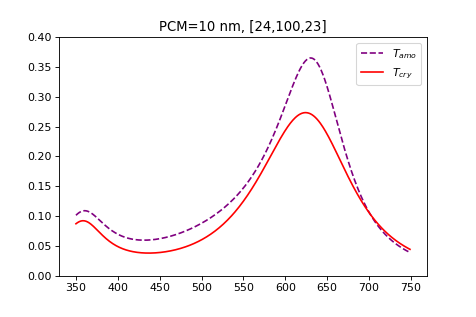

51


In [28]:
############## 1. Create background frame ###########
%matplotlib notebook
#fig, (ax1, ax2) = plt.subplots(1,2,figsize = (13,5))
fig, ax1 = plt.subplots()

thickness= np.arange(0,100,2)
print(thickness.shape[0]+1)
box_c= np.empty((thickness.shape[0],400 ))
box_a= np.empty((thickness.shape[0],400 ))

for i in range(thickness.shape[0]):
    a, b, c= input_parameters(thickness[i], 24,100,23, plot=False, results_return=False)
    box_c[i,:]= a
    box_a[i,:]= b
    x=c
    
def update(n):

    ax1.clear()    
    ax1.set_title('PCM={} nm, [24,100,23]'.format(thickness[n]))
    ax1.plot(x, box_a[n,:],'--',c= 'purple', label='$T_{amo}$')
    ax1.plot(x, box_c[n,:],'-',c= 'red', label='$T_{cry}$')
    ax1.set_ylim(0,0.4)
    ax1.legend()
    return ax1

ani = animation.FuncAnimation(fig, update, frames=thickness.shape[0], interval=500)
f = r"animation.gif" 
writergif = animation.PillowWriter(fps=100) 
ani.save(f,writer=writergif)
    